In [1]:
import gym
import random
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import time

#pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
env = gym.make('CartPole-v1')
start_time = time.time()

In [3]:
## E-greedy policy
def select_action(epsilon, state, net):
    #
    if np.random.random() < epsilon:
        ran_action = env.action_space.sample()
        return ran_action
    else:
        _ , max_action = net(state).max(-1)
        return max_action.item()

In [4]:
## Target update
def update_target_model(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    
def smooth_update_target_model(policy_net, target_net, update_target):
    rho = 1 - (1/update_target) #decay rate 
    for p_tgt, p in zip(target_net.parameters(),policy_net.parameters()):
        p_tgt.data.mul_(1.0 - rho)
        p_tgt.data.add_(rho*p.data) 

In [5]:
## Memory Replay
Transition = namedtuple('Transition', 
                        ('state','next_state','action','reward','mask'))

class Memory(object):
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
        self.capacity = capacity
        
    def push(self, state, next_state, action, reward, mask):
        self.memory.append(Transition(state, next_state, 
                                      action, reward, mask))
        
    def sample(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        batch = Transition(*zip(*transitions))
        return batch
    
    def __len__(self):
        return len(self.memory)

In [6]:
## Model
class DQN(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(num_inputs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_outputs)
            )
    def forward(self, x):
        return self.net(x)

In [7]:
## Train model
def train_model(policy_net, target_net, batch, optimizer,loss_fn, gamma):
    states = torch.stack(batch.state)
    next_states = torch.stack(batch.next_state)
    actions = torch.stack(batch.action).squeeze(1).float() 
    rewards = torch.tensor(batch.reward)
    masks = torch.tensor(batch.mask)
    
    qvalues = policy_net(states).squeeze(1)
    next_qvalues = target_net(next_states).squeeze(1)
    q_est = qvalues.mul(actions).sum(1)
    
    with torch.no_grad():
        target = rewards + masks*gamma*next_qvalues.max(1)[0]
        
    loss = loss_fn(q_est, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()
    

In [8]:
## Configurations
#hyperameters
batch_size = 64 
update_target = 200 
replay_memory_capacity = 1000000 
memory = Memory(replay_memory_capacity)
initial_exploration = 2000 
gamma = 0.995
lr = 1.0e-3 
epsilon = 1.0
num_episodes =  2*500
steps = 0
print_every = 50

#model 
num_inputs = 4
num_hidden = 256  
num_outputs = 2

#declare model
policy_net = DQN(num_inputs, num_hidden, num_outputs) 
target_net = DQN(num_inputs, num_hidden, num_outputs) 
update_target_model(policy_net, target_net) #copy weights

#optimizer & loss function
optimizer = optim.Adam(policy_net.parameters(), lr=lr)
loss_fn = nn.MSELoss()

In [9]:
## Training
#hyperameters


avg_loss,losses = [],[]
cum_rewards = []
cum_running_score = []
epsilon_cum = []

for episode in range(num_episodes):
    done = False
    
    score = 0
    obs = env.reset()
    state = torch.tensor(obs).unsqueeze(0)
    
    while not done:
        steps += 1
        action = select_action(epsilon, state, policy_net)
        next_obs, reward, done, _ = env.step(action)
        next_state = torch.tensor(next_obs).unsqueeze(0)
        
        mask = 0 if done else 1
        reward = -reward if done else reward
        score += reward
        
        action_one_hot = np.zeros(2)
        action_one_hot[action] = 1
        action_one_hot = torch.tensor(action_one_hot).unsqueeze(0)
        
        memory.push(state, next_state, action_one_hot, reward, mask)
        state = next_state
        
        if steps > initial_exploration:
            epsilon = max(epsilon*0.9995, 0.01)
            batch = memory.sample(batch_size)
            loss = train_model(policy_net, target_net, 
                               batch, optimizer, loss_fn, gamma)
            losses.append(loss)
            
        #smooth_tgt_update
        smooth_update_target_model(policy_net, 
                                   target_net, update_target)
                    
    if losses: #execute if not empty
        avg_loss.append( np.mean(losses) )
    
    epsilon_cum.append(epsilon)
    
    score = score #if score == 500.0 else score #+ 1
    cum_rewards.append(score)
    avg_reward = np.mean(cum_rewards[-10:])
    cum_running_score.append(avg_reward)
    
    if episode % print_every == 0:
        print("Episode: {} | Avg_reward: {}".format(episode,avg_reward))

Episode: 0 | Avg_reward: 31.0
Episode: 50 | Avg_reward: 24.0
Episode: 100 | Avg_reward: 21.2
Episode: 150 | Avg_reward: 98.1
Episode: 200 | Avg_reward: 382.1
Episode: 250 | Avg_reward: 352.4
Episode: 300 | Avg_reward: 326.3
Episode: 350 | Avg_reward: 316.4
Episode: 400 | Avg_reward: 401.9
Episode: 450 | Avg_reward: 330.6
Episode: 500 | Avg_reward: 363.1
Episode: 550 | Avg_reward: 404.0
Episode: 600 | Avg_reward: 406.9
Episode: 650 | Avg_reward: 374.5
Episode: 700 | Avg_reward: 338.4
Episode: 750 | Avg_reward: 405.2
Episode: 800 | Avg_reward: 370.0
Episode: 850 | Avg_reward: 384.2
Episode: 900 | Avg_reward: 350.9
Episode: 950 | Avg_reward: 409.4


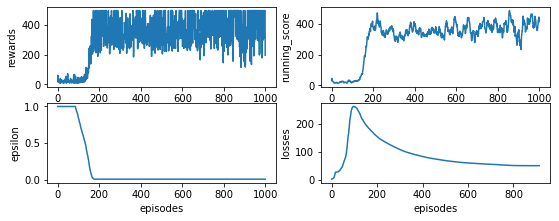

In [10]:
plt.figure(figsize=[9,5])
plt.subplot(3,2,1)
plt.plot(cum_rewards)
plt.ylabel('rewards')
#plt.xlabel('episodes')

plt.subplot(3,2,2)
#plt.plot(cum_rewards_b)
plt.plot(cum_running_score)
plt.ylabel('running_score')
#plt.xlabel('episodes')

plt.subplot(3,2,3)
plt.plot(epsilon_cum) 
plt.ylabel('epsilon')
plt.xlabel('episodes')

plt.subplot(3,2,4)
plt.plot(avg_loss)
plt.ylabel('losses')
plt.xlabel('episodes')

plt.show()

In [11]:
end_time = time.time()
print('execution time: ', end_time - start_time)

execution time:  562.1226217746735


In [13]:
duration = end_time - start_time
if duration > 3600: 
    print('{:.2f} hrs'.format(duration/3600))
else:
    print('{:.2f} min'.format(duration/60))

9.37 min
